# From Notebook to Kubernetes: Scaling GenAI Pipelines with ZenML

<div style="width: 100vw; margin-left: calc(50% - 50vw);">
    <img src="https://cdn.prod.website-files.com/64a817a2e7e2208272d1ce30/66c74b8f2f2804e73e8592b2_iterate00-min-p-800.png" style="width: 75%;">
</div>


# 1. ZenML Basics

## Default Local Stack

In [ ]:
from zenml.client import Client

client = Client()
client.activate_stack("default")

In [ ]:
from zenml import pipeline, step


@step
def my_step():
    print("Hello world!")


@pipeline
def my_pipeline():
    my_step()


my_pipeline()

![](assets/zenml_stacks.png)

## Kubernetes Stack

In [ ]:
from zenml.client import Client

client = Client()
client.activate_stack("az_k8s_pigeon")

In [ ]:
from settings import docker_settings, kubernetes_settings
from zenml import step, pipeline

@step
def k8s_step():
    print("Training model...")

@pipeline(
    settings={"orchestrator.kubernetes": kubernetes_settings, "docker": docker_settings}
)
def k8s_pipeline():
    k8s_step()

k8s_pipeline()

# 2. Let's get my cat ready for GenAI!

## (Local) Data Annotation

In [ ]:
from zenml.client import Client

client = Client()
client.activate_stack("local_with_azure_storage")

In [ ]:
import os

from zenml.client import Client
from IPython.display import display, Image

annotator = Client().active_stack.annotator

# get the image paths from data/cats-resized
image_paths = [os.path.join("/home/strickvl/coding/zenml-projects/mlops-community-demo/data/cats_resized", f) for f in os.listdir("/home/strickvl/coding/zenml-projects/mlops-community-demo/data/cats_resized")]

annotations = annotator.annotate(
    data=image_paths,
    options=[
        'blupus',
        'aria'
    ],
    display_fn=lambda filename: display(Image(filename))
)

### Separate out only the photos of Blupus

In [ ]:
import os
import json

base_dir = "/home/strickvl/coding/zenml-projects/mlops-community-demo"
# get the most recent annotation file
annotation_files = [f for f in os.listdir(os.path.join(base_dir, "annotations")) if f.endswith(".json")]
most_recent_annotation = max(
    (os.path.join(base_dir, "annotations", f) for f in annotation_files),
    key=os.path.getctime
)

with open(most_recent_annotation, 'r') as f:
    annotations = json.load(f)

# Create a list of all paths where the second element is 'blupus'
blupus_paths = [path for path, label in annotations if label == 'blupus']

blupus_paths

In [ ]:
# make copies of the blupus images in `blupus_paths` to the `data/blupus`
# subfolder

import os
import shutil

source_dir = "/home/strickvl/coding/zenml-projects/mlops-community-demo/data/cats-resized"
destination_dir = "/home/strickvl/coding/zenml-projects/mlops-community-demo/data/blupus"

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# copy the blupus images to the destination directory
for path in blupus_paths:
    shutil.copy(os.path.join(source_dir, path), destination_dir)

print(f"Copied {len(blupus_paths)} images to {destination_dir}")

## Data Augmentation with Albumentations

Using the Albumentations library to make a variety of transformations for our
images to augment our dataset a little. We'll avoid things that crop the image,
but we'll do things like change the brightness, contrast, and saturation. We'll
also do things like add noise, blur, and sharpen.

In [ ]:
import albumentations as A
import cv2

transform = A.Compose(
    [
        A.RandomBrightnessContrast(p=0.2),
        A.RandomGamma(p=0.2),
        A.RandomShadow(p=0.2),
        A.RandomRain(p=0.2),
        A.RandomSnow(p=0.2),
    ]
)

In [ ]:
import os

import numpy as np
from PIL import Image

data_dir = (
    "/home/strickvl/coding/zenml-projects/mlops-community-demo/data/blupus"
)
target_dir = (
    "/home/strickvl/coding/zenml-projects/mlops-community-demo/data/blupus_augmented"
)

# Ensure the target directory exists
os.makedirs(target_dir, exist_ok=True)

for filename in os.listdir(data_dir):
    if filename.endswith((".jpeg", ".jpg", ".png")):
        image_path = os.path.join(data_dir, filename)
        try:
            image = Image.open(image_path)
            image_np = np.array(image)

            # Apply the transformation
            transformed = transform(image=image_np)
            transformed_image = transformed["image"]

            # Convert back to PIL Image
            transformed_pil = Image.fromarray(transformed_image)

            # Save the augmented image
            augmented_filename = f"augmented_{filename}"
            augmented_path = os.path.join(target_dir, augmented_filename)
            transformed_pil.save(augmented_path)

            print(f"Saved augmented image: {augmented_filename}")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

print("Augmentation process completed.")

## Copy our images to the cloud

In [ ]:
from zenml import step
from zenml.utils import io_utils

base_source_dir = "/home/strickvl/coding/zenml-projects/mlops-community-demo/data/blupus"
augmented_source_dir = "/home/strickvl/coding/zenml-projects/mlops-community-demo/data/blupus_augmented"
# source_dir = "/home/strickvl/coding/zenml-projects/mlops-community-demo/data/blupus"
destination_dir = "az://demo-zenmlartifactstore/blupus"


@step
def copy_images():
    io_utils.makedirs(destination_dir)
    io_utils.copy_dir(source_dir, destination_dir, overwrite=True)
    io_utils.copy_dir(augmented_source_dir, destination_dir, overwrite=True)

In [ ]:
copy_images()

## Finetune a Model: Dreambooth Style with Flux

In [ ]:
from zenml.client import Client

client = Client()
client.activate_stack("az_k8s_pigeon")

### Code from Diffusers Examples

```python
import os

from rich import print
from settings import kubernetes_settings
from train_dreambooth_lora_flux import main as dreambooth_main
from zenml import step
from zenml.client import Client
from zenml.integrations.huggingface.steps import run_with_accelerate
from zenml.logger import get_logger
from zenml.utils import io_utils

logger = get_logger(__name__)

MNT_PATH = "/mnt/data"


def setup_hf_cache():
    if os.path.exists(MNT_PATH):
        os.environ["HF_HOME"] = MNT_PATH


@run_with_accelerate(
    num_processes=1, multi_gpu=False, mixed_precision="bf16"
)  # Adjust num_processes as needed
@step(
    settings={"orchestrator.kubernetes": kubernetes_settings},
)
def train_model(
    images_path: str,
    instance_name: str,
    class_name: str,
    model_name: str,
    hf_repo_suffix: str,
    prefix: str,
    resolution: int,
    train_batch_size: int,
    rank: int,
    gradient_accumulation_steps: int,
    learning_rate: float,
    lr_scheduler: str,
    lr_warmup_steps: int,
    max_train_steps: int,
    push_to_hub: bool,
    checkpointing_steps: int,
    seed: int,
) -> None:
    setup_hf_cache()

    images_dir_path = "/tmp/blupus/"
    _ = Client().active_stack.artifact_store.path

    io_utils.copy_dir(
        destination_dir=images_dir_path,
        source_dir=images_path,
        overwrite=True,
    )

    instance_phrase = f"{instance_name} the {class_name}"
    instance_prompt = f"{prefix} {instance_phrase}".strip()

    # Create an ArgumentParser-like object to mimic the args in the original script
    class Args:
        def __init__(self, **kwargs):
            self.mixed_precision = kwargs.get("mixed_precision", "bf16")
            self.pretrained_model_name_or_path = kwargs.get(
                "pretrained_model_name_or_path"
            )
            self.revision = kwargs.get("revision", None)
            self.variant = kwargs.get("variant", None)
            self.dataset_name = kwargs.get("dataset_name", None)
            self.dataset_config_name = kwargs.get("dataset_config_name", None)
            self.instance_data_dir = kwargs.get("instance_data_dir")
            self.cache_dir = kwargs.get("cache_dir", None)
            self.image_column = kwargs.get("image_column", "image")
            self.caption_column = kwargs.get("caption_column", None)
            self.repeats = kwargs.get("repeats", 1)
            self.class_data_dir = kwargs.get("class_data_dir", None)
            self.output_dir = kwargs.get("output_dir")
            self.instance_prompt = kwargs.get("instance_prompt")
            self.class_prompt = kwargs.get("class_prompt", None)
            self.max_sequence_length = kwargs.get("max_sequence_length", 512)
            self.validation_prompt = kwargs.get("validation_prompt", None)
            self.num_validation_images = kwargs.get("num_validation_images", 4)
            self.validation_epochs = kwargs.get("validation_epochs", 50)
            self.rank = kwargs.get("rank", 4)
            self.with_prior_preservation = kwargs.get(
                "with_prior_preservation", False
            )
            self.prior_loss_weight = kwargs.get("prior_loss_weight", 1.0)
            self.num_class_images = kwargs.get("num_class_images", 100)
            self.seed = kwargs.get("seed", None)
            self.resolution = kwargs.get("resolution", 512)
            self.center_crop = kwargs.get("center_crop", False)
            self.random_flip = kwargs.get("random_flip", False)
            self.train_text_encoder = kwargs.get("train_text_encoder", False)
            self.train_batch_size = kwargs.get("train_batch_size", 4)
            self.sample_batch_size = kwargs.get("sample_batch_size", 4)
            self.num_train_epochs = kwargs.get("num_train_epochs", 1)
            self.max_train_steps = kwargs.get("max_train_steps", None)
            self.checkpointing_steps = kwargs.get("checkpointing_steps", 500)
            self.checkpoints_total_limit = kwargs.get(
                "checkpoints_total_limit", None
            )
            self.resume_from_checkpoint = kwargs.get(
                "resume_from_checkpoint", None
            )
            self.gradient_accumulation_steps = kwargs.get(
                "gradient_accumulation_steps", 1
            )
            self.gradient_checkpointing = kwargs.get(
                "gradient_checkpointing", False
            )
            self.learning_rate = kwargs.get("learning_rate", 1e-4)
            self.guidance_scale = kwargs.get("guidance_scale", 3.5)
            self.text_encoder_lr = kwargs.get("text_encoder_lr", 5e-6)
            self.scale_lr = kwargs.get("scale_lr", False)
            self.lr_scheduler = kwargs.get("lr_scheduler", "constant")
            self.lr_warmup_steps = kwargs.get("lr_warmup_steps", 500)
            self.lr_num_cycles = kwargs.get("lr_num_cycles", 1)
            self.lr_power = kwargs.get("lr_power", 1.0)
            self.dataloader_num_workers = kwargs.get(
                "dataloader_num_workers", 0
            )
            self.weighting_scheme = kwargs.get("weighting_scheme", "none")
            self.logit_mean = kwargs.get("logit_mean", 0.0)
            self.logit_std = kwargs.get("logit_std", 1.0)
            self.mode_scale = kwargs.get("mode_scale", 1.29)
            self.optimizer = kwargs.get("optimizer", "AdamW")
            self.use_8bit_adam = kwargs.get("use_8bit_adam", False)
            self.adam_beta1 = kwargs.get("adam_beta1", 0.9)
            self.adam_beta2 = kwargs.get("adam_beta2", 0.999)
            self.prodigy_beta3 = kwargs.get("prodigy_beta3", None)
            self.prodigy_decouple = kwargs.get("prodigy_decouple", True)
            self.adam_weight_decay = kwargs.get("adam_weight_decay", 1e-04)
            self.adam_weight_decay_text_encoder = kwargs.get(
                "adam_weight_decay_text_encoder", 1e-03
            )
            self.adam_epsilon = kwargs.get("adam_epsilon", 1e-08)
            self.prodigy_use_bias_correction = kwargs.get(
                "prodigy_use_bias_correction", True
            )
            self.prodigy_safeguard_warmup = kwargs.get(
                "prodigy_safeguard_warmup", True
            )
            self.max_grad_norm = kwargs.get("max_grad_norm", 1.0)
            self.push_to_hub = kwargs.get("push_to_hub", False)
            self.hub_token = kwargs.get("hub_token", None)
            self.hub_model_id = kwargs.get("hub_model_id", None)
            self.logging_dir = kwargs.get("logging_dir", "logs")
            self.allow_tf32 = kwargs.get("allow_tf32", False)
            self.report_to = kwargs.get("report_to", "tensorboard")
            self.local_rank = kwargs.get("local_rank", -1)
            self.prior_generation_precision = kwargs.get(
                "prior_generation_precision", None
            )

    # Usage example:
    args = Args(
        mixed_precision="bf16",
        pretrained_model_name_or_path=model_name,
        instance_data_dir=images_dir_path,
        output_dir=hf_repo_suffix,
        instance_prompt=instance_prompt,
        resolution=resolution,
        train_batch_size=train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        rank=rank,
        lr_scheduler=lr_scheduler,
        lr_warmup_steps=lr_warmup_steps,
        max_train_steps=max_train_steps,
        checkpointing_steps=checkpointing_steps,
        seed=seed,
        push_to_hub=push_to_hub if push_to_hub else False,
    )

    # Run the main function with the created args
    print("Launching dreambooth training script")
    dreambooth_main(args)

```

In [ ]:
from settings import flux_docker_settings, kubernetes_settings
from train import train_model
from zenml import pipeline, step


@pipeline(settings={"docker": flux_docker_settings})
def dreambooth_pipeline_flux(
    instance_name: str = "sks blupus",
    class_name: str = "cat",
    model_name: str = "black-forest-labs/FLUX.1-dev",
    hf_username: str = "strickvl",
    hf_repo_suffix: str = "flux-dreambooth-blupus",
    prefix: str = "A portrait photo of",
    resolution: int = 512,
    train_batch_size: int = 2,
    rank: int = 32,
    gradient_accumulation_steps: int = 1,
    learning_rate: float = 0.0002,
    lr_scheduler: str = "constant",
    lr_warmup_steps: int = 0,
    max_train_steps: int = 1300,
    push_to_hub: bool = True,
    checkpointing_steps: int = 500,
    seed: int = 117,
):
    images_path = "az://demo-zenmlartifactstore/blupus"
    train_model(
        images_path,
        instance_name=instance_name,
        class_name=class_name,
        model_name=model_name,
        hf_repo_suffix=hf_repo_suffix,
        prefix=prefix,
        resolution=resolution,
        train_batch_size=train_batch_size,
        rank=rank,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        lr_scheduler=lr_scheduler,
        lr_warmup_steps=lr_warmup_steps,
        max_train_steps=max_train_steps,
        push_to_hub=push_to_hub,
        checkpointing_steps=checkpointing_steps,
        seed=seed,
    )


dreambooth_pipeline_flux()

[Hugging Face Hub Link to Model Repo for Flux Blupus](https://huggingface.co/strickvl/flux-dreambooth-blupus)

## Dreambooth with Stable Diffusion

In [ ]:
from settings import sd_docker_settings, kubernetes_settings
from train_sd import train_model
from zenml import pipeline


@pipeline(settings={"docker": sd_docker_settings})
def dreambooth_pipeline_sd():
    train_model()


dreambooth_pipeline_sd()

[Hugging Face Hub Link to Model Repo for Stable Diffusion Blupus](https://huggingface.co/strickvl/sd-dreambooth-blupus)

## Inference Time: Make me a Blupus!

In [ ]:
from zenml.client import Client

client = Client()
client.activate_stack("az_k8s_pigeon")

In [ ]:
from diffusers import AutoPipelineForText2Image
from PIL import Image as PILImage
from train import setup_hf_cache
from settings import kubernetes_settings, docker_settings
import torch
from zenml import step, pipeline

@step(settings={"orchestrator.kubernetes": kubernetes_settings})
def batch_inference(
    hf_username: str,
    hf_repo_suffix: str,
    instance_name: str,
    class_name: str,
) -> PILImage.Image:
    setup_hf_cache()

    model_path = f"{hf_username}/{hf_repo_suffix}"
    pipe = AutoPipelineForText2Image.from_pretrained(
        "black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16
    ).to("cuda")
    pipe.load_lora_weights(
        model_path, weight_name="pytorch_lora_weights.safetensors"
    )

    instance_phrase = f"{instance_name} the {class_name}"
    prompts = [
        f"A portrait photo of {instance_phrase} sitting on a laptop keyboard",
        f"A portrait photo of {instance_phrase} wearing VR goggles",
        f"A portrait photo of {instance_phrase} next to a glowing computer screen",
        f"A portrait photo of {instance_phrase} with a smart collar",
        f"A portrait photo of {instance_phrase} in front of a server rack",
        f"A portrait photo of {instance_phrase} with robotic ears",
        f"A portrait photo of {instance_phrase} on a hoverboard",
        f"A portrait photo of {instance_phrase} with holographic whiskers",
        f"A portrait photo of {instance_phrase} in a futuristic cat carrier",
        f"A portrait photo of {instance_phrase} in a data center",
        f"A portrait photo of {instance_phrase} next to a 3D printer",
        f"A portrait photo of {instance_phrase} with a cybernetic tail",
        f"A portrait photo of {instance_phrase} in a self-driving cat bed",
        f"A portrait photo of {instance_phrase} wearing a space helmet",
        f"A portrait photo of {instance_phrase} with a digital fish hologram",
    ]

    images = pipe(
        prompt=prompts,
        num_inference_steps=35,
        guidance_scale=8.5,
        height=256,
        width=256,
    ).images

    width, height = images[0].size
    rows, cols = 3, 5
    gallery_img = PILImage.new("RGB", (width * cols, height * rows))

    for i, image in enumerate(images):
        gallery_img.paste(image, ((i % cols) * width, (i // cols) * height))

    return gallery_img

@pipeline(settings={"docker": docker_settings})
def inference_pipeline():
    batch_inference(hf_username="strickvl", hf_repo_suffix="flux-dreambooth-blupus", instance_name="sks blupus", class_name="cat")

inference_pipeline()

### Stable Diffusion Model

In [ ]:
from zenml.client import Client

client = Client()
client.activate_stack("local_with_azure_storage")

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "strickvl/sd-dreambooth-blupus"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, force_download=True)
pipe = pipe.to(device)


In [ ]:

prompt = "a portrait photo of sks blupus the cat in delft"
image = pipe(prompt, num_inference_steps=80, guidance_scale=7.5, height=512, width=512).images[0]
image

### Flux Model

In [1]:
from diffusers import AutoPipelineForText2Image
import torch

model_id = "black-forest-labs/FLUX.1-schnell"
lora_id = "strickvl/flux-dreambooth-blupus"

# Load the pipeline with float16 precision
pipeline = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True)

# Enable attention slicing
pipeline.enable_attention_slicing()

# Enable model offloading
pipeline.enable_model_cpu_offload()

# Load LoRA weights
pipeline.load_lora_weights(lora_id, weight_name='pytorch_lora_weights.safetensors')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

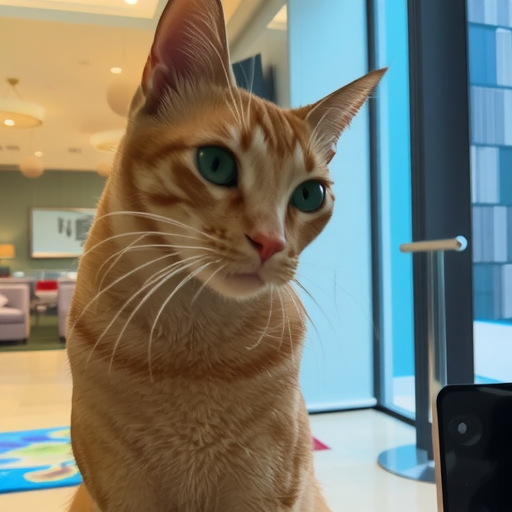

In [7]:
image = pipeline('A portrait photo of sks blupus the cat the Sheraton hotel lobby', num_inference_steps=30, guidance_scale=8.5, height=512, width=512).images[0]
image

## Do it in a pipeline!

In [ ]:
from diffusers import AutoPipelineForText2Image
import torch
from zenml import step
from PIL import Image as PILImage

@step
def flux_inference() -> PILImage.Image:
    model_id = "black-forest-labs/FLUX.1-schnell"
    lora_id = "strickvl/flux-dreambooth-blupus"

    # Load the pipeline with float16 precision
    pipeline = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True)

    # Enable attention slicing
    pipeline.enable_attention_slicing()

    # Enable model offloading
    pipeline.enable_model_cpu_offload()

    # Load LoRA weights
    pipeline.load_lora_weights(lora_id, weight_name='pytorch_lora_weights.safetensors')
    image = pipeline('A portrait photo of sks blupus the cat', num_inference_steps=20, guidance_scale=8.5, height=512, width=512).images[0]
    return image


In [ ]:
flux_inference()

# Join the ZenML Community!

**Try out ZenML!** https://github.com/zenml-io/zenml

Read more about what we're building at ZenML https://zenml.io

Join the community on **Slack**! https://zenml.io/slack
